In [1]:
import shap
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
import io
import warnings

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Misc

In [3]:
columns_map = {
    "plaque_volume": "Plaque volume",
    "iph_volume": "IPH volume",
    "lipid_minus_iph": "(Lipid - IPH) volume",
    "lipid_volume": "Lipid volume",
    "mixed_volume": "Mixed volume",
    "calcium_volume": "Calcium volume",
    "perc_lipid": "Lipid volume (%)",
    "perc_mixed": "Mixed volume (%)",
    "perc_calcium": "Calcium volume (%)",
    "perc_iph": "IPH volume (%)",
    "perc_lipid_minus_iph": "(Lipid - IPH) volume (%)",
    "iph_total_lipid_ratio": "IPH / lipid volume",
    "hypertension": "Hypertension",
    "CAD": "CAD",
    "smoker": "Smoker",
    "age": "Age",
    "gender": "Male",
    "diabetes": "Diabetes",
    "lipids": "Hyperlipidemia",
    "stenosis": "Stenosis",
    "iph": "Intraplaque Hemorrhage",
    "symptpoms": "Symptomatic Status",
    'lipid_minus_iph x perc_iph': "(Lipid - IPH) x IPH (%) volumes",
    'lipid_minus_iph x iph_total_lipid_ratio': "(Lipid - IPH) x IPH / lipid volume",
    'perc_calcium x iph_total_lipid_ratio': "Calcium (%) x IPH / lipid volume",
    'iph_volume x iph_total_lipid_ratio': "IPH volume x IPH / lipid volume",
    'perc_iph x iph_total_lipid_ratio': "IPH (%) x IPH / lipid volume",
    'perc_lipid x iph_total_lipid_ratio': "Lipid (%) x IPH / lipid volume",
    'iph_total_lipid_ratio x age': "IPH / lipid volume x age"
}

In [4]:
from matplotlib.cm import register_cmap, get_cmap
import matplotlib.colors as clr
blue = "#4974a5"
lightblue = "#b0c4de"
salmon = "#ff8c69"
lightsalmon = "#FFD1C2"
darksalmon = "#e57e5e"

custom_cmap = clr.LinearSegmentedColormap.from_list('custom cmap', [lightblue, salmon], N=256)

In [5]:
def load_obj(path):
    with open(path, "rb") as f_r:
        obj = pickle.load(f_r)

    return obj

# Load model and predictions

In [6]:
#probas = pd.read_csv("../output/predictions/external_test_preds_LGBM_final.csv")
#pos_class_proba = probas["proba"]

# Load training set

In [7]:
train = pd.read_csv("../input/train.csv")
X_train, y_train = train.drop('symptoms', axis=1), train['symptoms']

#X_train = X_train.drop(["site", "patient_ID", "infarct_side", "stroke", "TIA"], axis=1)
X_train_nr = X_train.copy()

le = LabelEncoder()
oe = OrdinalEncoder()

to_encode = ["hypertension", "CAD", "gender", "diabetes", "lipids", "smoker", "stenosis", "iph"]

y_train = le.fit_transform(y_train)
X_train_nr[to_encode] = oe.fit_transform(X_train_nr[to_encode]).astype(np.uint8)

# convert uint8 dtypes to categorical
cat_cols = X_train_nr.select_dtypes(include=np.uint8).columns.tolist()
X_train_nr[cat_cols] = X_train_nr[cat_cols].astype("category")

X_train_renamed = X_train_nr.rename(columns=columns_map)
X_train_nr = X_train_nr.rename(columns=columns_map)

X_train_fancy = X_train_nr.copy()
bin_features = X_train_fancy.select_dtypes(include="category").columns.tolist()
for c in bin_features:
    X_train_fancy[c] = X_train_fancy[c].apply(lambda v: "Yes" if v == 1 else "No")

In [8]:
X_train_noscale = X_train.copy()

# Load external validation set

In [9]:
test = pd.read_csv("../input/external.csv")
X_test, y_test = test.drop('symptoms', axis=1), test['symptoms']

X_test_nr = X_test.copy()

le = LabelEncoder()
oe = OrdinalEncoder()

to_encode = ["hypertension", "CAD", "gender", "diabetes", "lipids", "smoker", "stenosis", "iph"]

y_test = le.fit_transform(y_test)
X_test_nr[to_encode] = oe.fit_transform(X_test_nr[to_encode]).astype(np.uint8)

# convert uint8 dtypes to categorical
cat_cols = X_test_nr.select_dtypes(include=np.uint8).columns.tolist()
X_test_nr[cat_cols] = X_test_nr[cat_cols].astype("category")

X_test_renamed = X_test_nr.rename(columns=columns_map)
X_test_nr = X_test_nr.rename(columns=columns_map)

X_test_fancy = X_test_nr.copy()
bin_features = X_test_fancy.select_dtypes(include="category").columns.tolist()
for c in bin_features:
    X_test_fancy[c] = X_test_fancy[c].apply(lambda v: "Yes" if v == 1 else "No")

In [10]:
X_test_noscale = X_test.copy()

In [10]:
numeric_cols = X_train.select_dtypes(include=np.float64).columns.tolist()
scaler = StandardScaler()
X_train.loc[:, numeric_cols] = scaler.fit_transform(X_train.loc[:, numeric_cols])
X_test.loc[:, numeric_cols] = scaler.transform(X_test.loc[:, numeric_cols])

In [59]:
y_test.mean(), y_train.mean()

(0.29245283018867924, 0.2875)

# Try EBM

In [11]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

In [12]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

In [13]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
cv = RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=1303)

In [999]:
numeric_cols = X_train.select_dtypes(include=np.float64).columns.tolist()
scaler = StandardScaler()
X_train.loc[:, numeric_cols] = scaler.fit_transform(X_train.loc[:, numeric_cols])
X_test.loc[:, numeric_cols] = scaler.transform(X_test.loc[:, numeric_cols])

In [377]:
aucs = []
subset = ["iph_total_lipid_ratio"]
for i, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    print(f"{i+1}", end=" ")
    Xtrain, ytrain = X_train.iloc[train_idx].copy(), y_train[train_idx]
    Xtest, ytest = X_train.iloc[test_idx].copy(), y_train[test_idx]
    
    numeric_cols = Xtrain.select_dtypes(include=np.float64).columns.tolist()
    scaler = StandardScaler()
    Xtrain.loc[:, numeric_cols] = scaler.fit_transform(Xtrain.loc[:, numeric_cols])
    Xtest.loc[:, numeric_cols] = scaler.transform(Xtest.loc[:, numeric_cols])
    
    ebm = ExplainableBoostingClassifier(random_state=1303, interactions=6,
                                       learning_rate=0.01,
                                       min_samples_leaf=2,
                                        outer_bags=25,
                                        inner_bags=25,
                                        max_bins=64,
                                       max_leaves=5,
                                       n_jobs=10)
    
    ebm.fit(Xtrain[subset], ytrain)
    y_pred_proba = ebm.predict_proba(Xtest[subset])[:, 1]
    
    auc = roc_auc_score(ytest, y_pred_proba)
    aucs.append(auc)
    
print("{:.2f}".format(np.median(aucs)))

1 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3 4 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

5 6 7 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

8 9 10 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

11 12 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

13 14 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

15 16 17 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

18 19 20 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

21 22 23 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

24 25 26 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

27 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



28 29 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

30 31 32 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

33 34 35 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

36 37 38 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

39 40 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

41 42 43 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

44 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



45 46 47 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

48 49 50 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

51 52 53 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

54 55 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

56 57 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

58 59 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

60 61 62 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

63 64 65 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

66 67 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

68 69 70 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

71 72 73 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

74 75 76 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

77 78 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

79 80 81 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

82 83 84 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

85 86 87 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

88 89 90 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

91 92 93 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

94 95 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

96 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



97 98 99 

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

100 0.90


/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_61139/3263492819.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Calibration plot

In [30]:
def ntile_name(n):
    """Returns the ntile name corresponding to an ntile integer.
    Parameters
    ----------
    n : int
        An ntile integer.
    Returns
    -------
    ntile_name : str
        The corresponding ntile name.
    """
    ntile_names = {
        4: 'Quartile',
        5: 'Quintile',
        6: 'Sextile',
        10: 'Decile',
        12: 'Duodecile',
        20: 'Vigintile',
        100: 'Percentile'
    }
    return ntile_names.get(n, '{}-tile'.format(n))

def make_recarray(y_true, y_pred):
    """Combines arrays into a recarray.
    Parameters
    ----------
    y_true : array
        Observed labels, either 0 or 1.
    y_pred : array
        Predicted probabilities, floats on [0, 1].
    Returns
    -------
    table : recarray
        A record array with observed label and predicted probability
        columns, sorted by predicted probability.
    """
    recarray = np.recarray(len(y_true), [('y_true', 'u8'), ('y_pred', 'f8')])
    recarray['y_true'] = y_true
    recarray['y_pred'] = y_pred
    recarray.sort(order='y_pred')
    return recarray

def hosmer_lemeshow_table(y_true, y_pred, n_bins=10):
    """Constructs a Hosmer–Lemeshow table.
    Parameters
    ----------
    y_true : array
        Observed labels, either 0 or 1.
    y_pred : array
        Predicted probabilities, floats on [0, 1].
    n_bins : int, optional
        The number of groups to create. The default value is 10, which
        corresponds to deciles of predicted probabilities.
    Returns
    -------
    table : recarray
        A record array with `n_bins` rows and four columns: Group Size,
        Observed Frequency, Predicted Frequency, and Mean Probability.
    """
    print(y_true.shape, y_pred.shape)
    if n_bins < 2:
        raise ValueError('Number of groups must be greater than or equal to 2')

    if n_bins > len(y_true):
        raise ValueError('Number of predictions must exceed number of groups')

    table = make_recarray(y_true, y_pred)

    table = [(len(g), g.y_true.sum(), g.y_pred.sum(), g.y_pred.mean())
             for g in np.array_split(table, n_bins)]
    names = ('group_size', 'obs_freq', 'pred_freq', 'mean_prob')
    table = np.rec.fromrecords(table, names=names)

    return table
    
def hosmer_lemeshow_plot(y_true, y_pred, n_bins=20, colors=('blue', 'red')):
    table = hosmer_lemeshow_table(y_true, y_pred, n_bins)
    # transform observed and predicted frequencies in percentage
    # relative to the bin dimension
    
    obs_freq = table.obs_freq
    pred_freq = table.pred_freq
    group_size = table.group_size
    print(group_size, obs_freq, pred_freq)
    
    trans_obs_freq = []
    trans_pred_freq = []
    for (gs, of, pf) in zip(group_size, obs_freq, pred_freq):
        trans_of = (of/gs) * 100
        trans_pf = (pf/gs) * 100
        
        trans_obs_freq.append(trans_of)
        trans_pred_freq.append(trans_pf)
    
    trans_obs_freq = np.array(trans_obs_freq)
    trans_pred_freq = np.array(trans_pred_freq)
    
    index = np.arange(n_bins)

    width = 0.9

    fig, ax = plt.subplots(figsize=(8, 4))
    

    #ax.bar(index+0.08, (np.append(table.obs_freq, 0) / len(y_true))*100 , width, color=colors[1], label='Observed',
    #       align="edge", edgecolor="#FF531F")
    barplot = ax.bar(index+0.08, trans_obs_freq, width, color=colors[1], label='Observed',
           align="edge", 
                     #edgecolor="#FF531F"
                    )    
    
    for of, bar in zip(obs_freq, barplot.patches):
        ax.annotate(of,
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=15, xytext=(-2, 10),
                       textcoords='offset points')

    
    ax2 = ax.twinx()
    
    line_points = [(index[i] + index[i+1]) / 2 for i in range(len(index)-1)] + [9.5]
    ax2.plot(line_points, trans_pred_freq/100, color=colors[0], label='Predicted', marker="s")

    ax.set_xlabel('{} of Predicted Probabilities'.format(ntile_name(n_bins)))
    ax.set_ylabel('Observed: Proportion of Events (%)')
    ax2.set_ylabel('Predicted: ML score', color="#3E7CB1", )
    

    ax.set_xticks(index, index)
    
    ax.set_ylim([0, 110])
    ax2.set_ylim([0, 1.10])
    #ax.set_yticklabels()
    #ax.set_yticklabels([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20])
    #ax2.set_yticklabels(["0", 0.025, "0.50", 0.075, "0.10", 0.125, 0.150, 0.175, 0.20])
    
    plt.title('Observed vs. Predicted Probability of Symptomatic Status')
    fig.legend(frameon=False, ncol=2, bbox_to_anchor=(0.65, 0.02))
    
    new_xticks = np.append(ax.get_xticks(), 10)
    ax.set_xticks(new_xticks, new_xticks)
    
    return ax

(106,) (106,)
[11 11 11 11 11 11 10 10 10 10] [ 0  0  1  1  2  1  1  7  8 10] [0.13895158 0.19753675 0.27188956 0.37116501 0.50439878 0.71900485
 1.43301027 4.13509234 7.41174235 8.82581286]


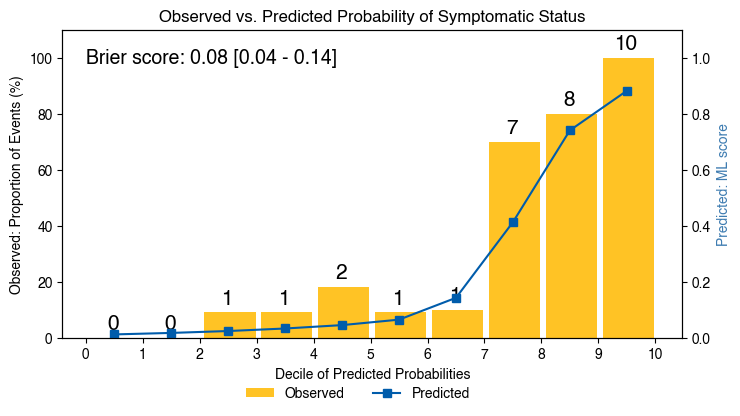

In [31]:
plt.rcParams["font.family"] = "Helvetica"

ebm = load_obj("../output/fitted_models/ebm_all.pkl")
y_pred_proba = ebm.predict_proba(X_test_noscale)[:, 1]

ax = hosmer_lemeshow_plot(y_test, y_pred_proba, n_bins=10, colors=["#005CAB", "#FFC325"])

ax.text(0, 98, "Brier score: 0.08 [0.04 - 0.14]", clip_on=False, fontsize=14)



plt.savefig("../output/plots/TIFF/calibration.tiff", format="tiff", dpi=500,
                bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})

plt.show()

We pair ground-truths and predicted probabilities and sort them by pred proba.
A good classifier will produce probabilities closer to 1 for subjects with ground truth 1, and proba. closer to 0 for subjects with ground truth 0.
Next, we split this list of pairs in bins, e.g., 10 (deciles).
For each bin, we sum ground-truths and pred. proba.
E.g., bin 7-8 shows 7. This means that among all observations that are present in that bin, 7 had ground-truth 1. 
In our case, M = 106 and N_BINS = 10. 106/10 ~= 11. Most bins will have 11 observations and some will have 10.
bin 7-8 have 10 observations
Observed frequency for bin 7-8: 7 / 10 = 70% (y axis on the left, the yellow bar's height is 70%). 
For the actual/predicted frequency, we sum the predicted probability associated to those 10 observations in the bin.
If the model is good, pred proba for ground-truth = 0 will be closer to 0, and pred proba for ground-truth 1 will be closer to 1. Thus, we expect an actual frequency of ~= 7. In our case, the pred freq was 4 (4/10 = 40%, it is 30% off).
In general, the two y axes must be on the same "scale". On the left, observed frequency in percentage from 0 to 100(sum of ground-truths/bin size * 100; on the right, predicted probability by the ML model, from 0 to 1. There is a correspondence between predicted/actual frequency (e.g., 4.13) and predicted ML score, which is pred freq / 10, 0.413 on the right y axis. 

# ROC curves

In [14]:
import pandas as pd
import numpy as np
import scipy.stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return 10**calc_pvalue(aucs, delongcov).item()

In [15]:
def plot_rocs(cv_preds, ax, color, model_keys, bars_pos=[0.41,0.01,0.53,0.30]):
    auc_cis = dict()
    for j, (algo_name, outer_cv_data) in enumerate(cv_preds.items()):
        fprs = np.linspace(0, 1, 100)
        tprs = []
        aucs = []
        outer_cv_data = outer_cv_data["EBM"]
        gts = outer_cv_data['gt']
        probas = outer_cv_data['probas']

        for split_idx, (split_gts, split_probas) in enumerate(zip(gts, probas)):
            auc_val = roc_auc_score(split_gts, split_probas[:, 1])
            aucs.append(auc_val)

            # compute ROC curve components
            fpr, tpr, _ = roc_curve(split_gts, split_probas[:, 1])
            tprs.append(np.interp(fprs, fpr, tpr))

        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std_tprs = tprs.std(axis=0)
        tprs_upper = np.minimum(mean_tprs + std_tprs, 1)
        tprs_lower = mean_tprs - std_tprs

        fpr, tpr, thresholds = roc_curve(outer_cv_data['gt_conc'], outer_cv_data['probas_conc'][:, 1])

        auc_low, auc_med, auc_up = np.percentile(aucs, [2.5, 50, 97.5])
        auc_cis[algo_name] = {"auc": auc_med, "ci_low": auc_low, "ci_up": auc_up}

        ax.plot(fpr,
                tpr,
                linestyle='-',
                alpha=1.0,
                linewidth=2,
                color=colors[j])

    ax.set_xlabel('1 - Specificity',
                  fontdict={"weight": "bold", "size": 20},
                  labelpad=20)
    ax.set_ylabel('Sensitivity',
                  fontdict={"weight": "bold", "size": 20},
                  labelpad=20)
    
    #plt.xticks(np.arange(0, 1.1, 0.1), fontsize=20)
    #plt.yticks(np.arange(0, 1.1, 0.1), fontsize=20)
    #plt.xticks(np.arange(0, 1.1, 0.1), fontsize=15)
    #plt.yticks(np.arange(0, 1.1, 0.1), fontsize=15)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label="Baseline", alpha=.8)
    
    
    ins = ax.inset_axes(bars_pos)
    ins.spines['top'].set_visible(False)
    ins.spines['right'].set_visible(False)
    ins.spines['bottom'].set_visible(False)
    
    ins.get_xaxis().set_ticks([])
    
    model_names = model_keys
    model_aucs = [v["auc"] for _, v in auc_cis.items()]
    model_cis_low = np.array([v["auc"] - v["ci_low"] for _, v in auc_cis.items()])
    model_cis_up = np.array([v["ci_up"] - v["auc"] for _, v in auc_cis.items()])
    
    all_data = list(zip(model_names, model_aucs, model_cis_low, model_cis_up, colors))
    all_data.sort(key=lambda x: x[1], reverse=False)
    
    model_names = [t[0] for t in all_data]
    model_aucs = [t[1] for t in all_data]
    model_cis_low = [t[2] for t in all_data]
    model_cis_up = [t[3] for t in all_data]
    model_colors = [t[4] for t in all_data]

    ins.barh(range(4), model_aucs, 
             xerr=[model_cis_low, model_cis_up], 
             align="center",
             color=model_colors,
             capsize=3,
             error_kw=dict(linewidth=1)
            )
    ins.invert_yaxis()
    ins.set_yticks(range(4), labels=model_names, fontsize=13)
    
    for i, (name, auc, bar) in enumerate(zip(model_names, model_aucs, ins.patches)):
        ins.annotate(f"{auc:.3f}",
                    (bar.get_width(),
                     bar.get_y() + bar.get_height() / 2), ha='left', va='center',
                    size=18, 
                     #xytext=(17, -1) if name != "Clinical" else (32,-1),
                     xytext=(0.04, i), color="w" if name != "ML all" else "#4F4045",
                    #textcoords='offset points'
                     textcoords='data'
                    )
    ins.set_title("AUC (bars) and 95% CI (whiskers)", fontsize=18)
    
    return ax, ins, auc_cis

In [16]:
def format_P(P, alpha=0.05):
    return f"P < .001" if P < alpha else f"P = {P:.3f}".replace("0", "")

In [17]:
all_cv = load_obj("../output/predictions/cv_pooled_preds_all.pkl")
plaque_cv = load_obj("../output/predictions/cv_pooled_preds_only_plaque.pkl")
clinical_cv = load_obj("../output/predictions/cv_pooled_preds_only_clinical.pkl")
ratio_cv = load_obj("../output/predictions/cv_pooled_preds_only_ratio.pkl")

probas = {"ML all": all_cv,
          "ML plaque": plaque_cv,
          "ML clinical": clinical_cv,
          "ML ratio": ratio_cv}

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve
from copy import deepcopy

plt.rcParams["font.family"] = "Helvetica"

colors = ["#FFC325", "#E31B23", "#005CAB", "#9A348E"]


# Precision-recall curves

In [19]:
from sklearn.metrics import average_precision_score, precision_recall_curve

def plot_average_pr_curves(cv_preds, ax, color, model_keys, bars_pos=[0.32,0.01,0.6,0.24]):
    auc_cis = dict()
    
    for j, (algo_name, outer_cv_data) in enumerate(cv_preds.items()):
        precisions = []
        recalls = np.linspace(0, 1, 100)
        pr_aucs = []

        gts = outer_cv_data["EBM"]['gt']
        probas = outer_cv_data["EBM"]['probas']

        for split_idx, (split_gts, split_probas) in enumerate(zip(gts, probas)):
            pr_auc = average_precision_score(split_gts, split_probas[:, 1])
            pr_aucs.append(pr_auc)

            # compute ROC curve components
            precision, recall, _ = precision_recall_curve(split_gts, split_probas[:, 1])
            precision, recall = precision[::-1], recall[::-1]

            prec_array = np.interp(recalls, recall, precision)
            precisions.append(prec_array)

        mean_prec = np.mean(precisions, axis=0)
        std_prec = np.std(precisions, axis=0)

        prec, rec, _ = precision_recall_curve(outer_cv_data["EBM"]['gt_conc'], 
                                              outer_cv_data["EBM"]['probas_conc'][:, 1])

        pr_auc_low, pr_auc_med, pr_auc_up = np.percentile(pr_aucs, [2.5, 50, 97.5])
        auc_cis[algo_name] = {"auc": pr_auc_med, "ci_low": pr_auc_low, "ci_up": pr_auc_up}

        ax.plot(rec,
                prec,
                alpha=1.0,
                color=colors[j],
        )

    ax.set_xlabel('Recall',
                  fontdict={"weight": "bold", "size": 20},
                  labelpad=20)
    ax.set_ylabel('Precision',
                  fontdict={"weight": "bold", "size": 20},
                  labelpad=20)

    #plt.xticks(np.arange(0, 1.1, 0.1), fontsize=15)
    #plt.yticks(np.arange(0, 1.1, 0.1), fontsize=15)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)    

    # draw baseline
    tot_pos = outer_cv_data["EBM"]['gt_conc'].sum()
    tot = len(outer_cv_data["EBM"]['gt_conc'])
    baseline = tot_pos / tot
    plt.axhline(y=baseline, color='gray', linestyle='--', lw=1, alpha=.8,
                label='Baseline')
    
    ins = ax.inset_axes(bars_pos)
    ins.spines['top'].set_visible(False)
    ins.spines['right'].set_visible(False)
    ins.spines['bottom'].set_visible(False)
    
    ins.get_xaxis().set_ticks([])
    
    #model_names = ["All", "Quantitative plaque", "Clinical", "IPH/Lipid ratio"]
    model_names = model_keys
    model_aucs = [v["auc"] for _, v in auc_cis.items()]
    model_cis_low = np.array([v["auc"] - v["ci_low"] for _, v in auc_cis.items()])
    model_cis_up = np.array([v["ci_up"] - v["auc"] for _, v in auc_cis.items()])
    
    all_data = list(zip(model_names, model_aucs, model_cis_low, model_cis_up, colors))
    all_data.sort(key=lambda x: x[1], reverse=False)
    
    model_names = [t[0] for t in all_data]
    model_aucs = [t[1] for t in all_data]
    model_cis_low = [t[2] for t in all_data]
    model_cis_up = [t[3] for t in all_data]
    model_colors = [t[4] for t in all_data]

    ins.barh(range(4), model_aucs, 
             xerr=[model_cis_low, model_cis_up], 
             align="center",
             color=model_colors,
             capsize=3,
             error_kw=dict(linewidth=1)
            )    
    
    ins.invert_yaxis()
    ins.set_yticks(range(4), labels=model_names, fontsize=13)

    for i, (name, auc, bar) in enumerate(zip(model_names, model_aucs, ins.patches)):
        ins.annotate(f"{auc:.2f}",
                    (bar.get_width(),
                     bar.get_y() + bar.get_height() / 2), ha='left', va='center',
                    size=16, 
                     #xytext=(55, -1) if name != "Clinical" else (50,-1),
                     xytext=(0.04, i), color="w" if name != "ML all" else "#4F4045",
                    #textcoords='offset points'
                     textcoords='data'
                    )
    ins.set_title("AUC (bars) and 95% CI (whiskers)", fontsize=18)    
    
    return ax, ins, auc_cis

In [20]:
ground_truths = probas["ML all"]["EBM"]['gt_conc']
probas_all = probas["ML all"]["EBM"]["probas_conc"][:, 1]
probas_plaque = probas["ML plaque"]["EBM"]["probas_conc"][:, 1]
probas_clinical = probas["ML clinical"]["EBM"]["probas_conc"][:, 1]    
probas_ratio = probas["ML ratio"]["EBM"]["probas_conc"][:, 1]

P_all_clinical = format_P(delong_roc_test(ground_truths, probas_all, probas_clinical))
P_plaque_ratio = format_P(delong_roc_test(ground_truths, probas_plaque, probas_ratio))
P_plaque_clinical = format_P(delong_roc_test(ground_truths, probas_plaque, probas_clinical))
P_all_plaque = format_P(delong_roc_test(ground_truths, probas_all, probas_plaque))
P_all_ratio = format_P(delong_roc_test(ground_truths, probas_all, probas_ratio))

In [24]:
P_all_ratio, P_all_plaque

('P = .621', 'P = .241')

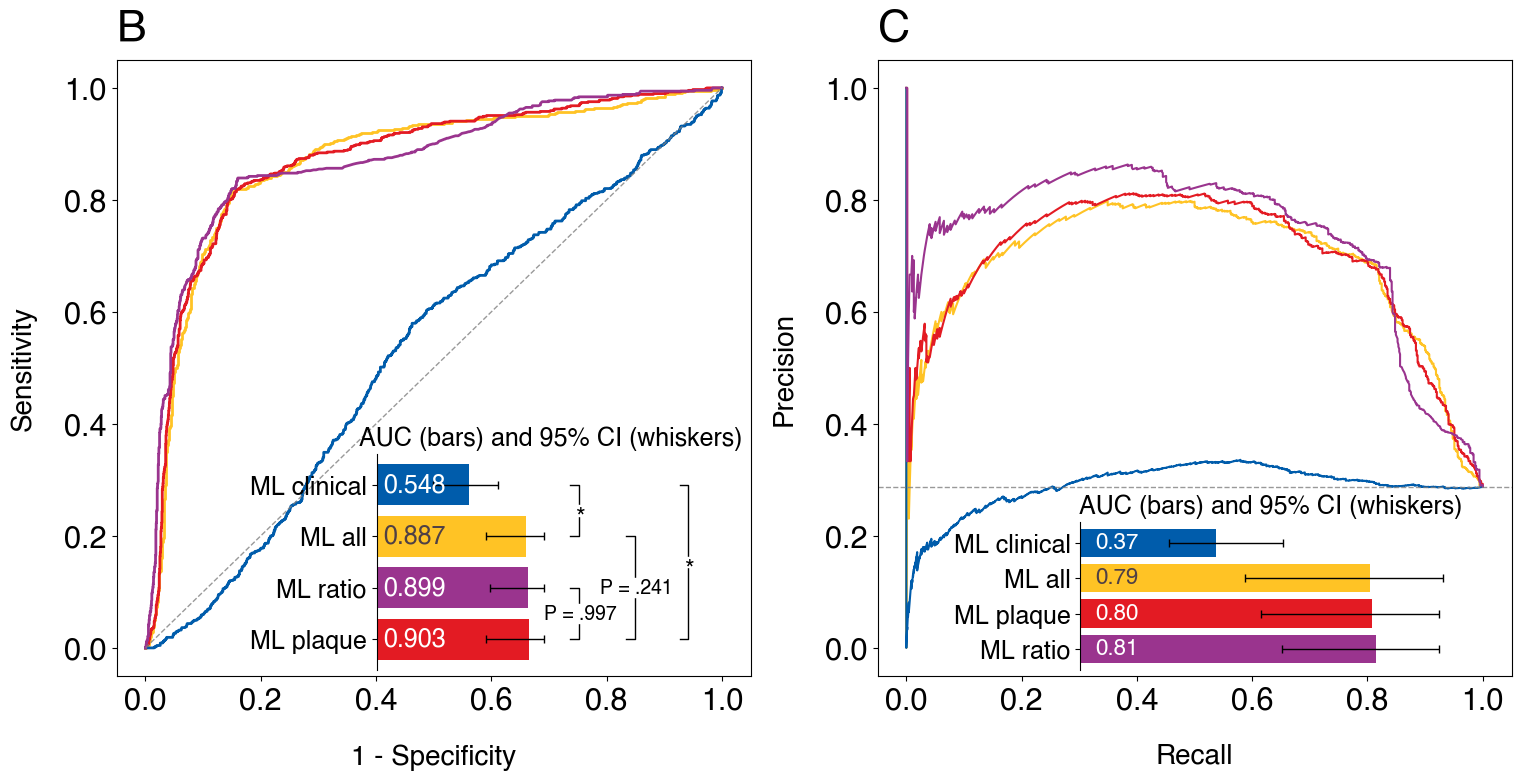

In [324]:
colors = ["#FFC325", "#E31B23", "#005CAB", "#9A348E"]

f, axes = plt.subplots(1, 2, figsize=(18, 8))

model_names = ["ML all", "ML plaque", "ML clinical", "ML ratio"]

ax1, barplot_roc, roc_aucs_data = plot_rocs(probas, 
                                            axes[0], 
                                            color=colors, 
                                            model_keys=model_names,
                                            bars_pos=[0.41,0.01,0.55,0.35])

ground_truths = probas["ML all"]["EBM"]['gt_conc']
probas_all = probas["ML all"]["EBM"]["probas_conc"][:, 1]
probas_plaque = probas["ML plaque"]["EBM"]["probas_conc"][:, 1]
probas_clinical = probas["ML clinical"]["EBM"]["probas_conc"][:, 1]    
probas_ratio = probas["ML ratio"]["EBM"]["probas_conc"][:, 1]

P_all_clinical = format_P(delong_roc_test(ground_truths, probas_all, probas_clinical))
P_plaque_ratio = format_P(delong_roc_test(ground_truths, probas_plaque, probas_ratio))
P_plaque_clinical = format_P(delong_roc_test(ground_truths, probas_plaque, probas_clinical))
P_all_plaque = format_P(delong_roc_test(ground_truths, probas_all, probas_plaque))
P_all_ratio = format_P(delong_roc_test(ground_truths, probas_all, probas_ratio))


def annot_stat(x, y1, y2, h, col='k', p="p = .05", fontsize=13, voffset = 0, ax=None):
    ax = plt.gca() if ax is None else ax
    
    x_pos = x+h+0.01
    y_pos = (y1+y2)/2 + voffset

    ax.plot([x, x+h, x+h, x], [y1, y1, y2, y2], lw=1, c=col)
    
    if p == "*":
        
        rect_w = 0.2
        rect_h = 0.2
        rect_x_offset = 0.01
        rect_y_offset = 0
        #0.045
        
        y_pos = (y1+y2)/2

        # text coordinates and content      
        ax.text(x_pos, y_pos + 0.15, p, ha='center', va='center', color=col,
                size=fontsize, zorder=10
               #bbox=dict(boxstyle='square,pad=0', facecolor="white", edgecolor="white")
               )

        rect = patches.Rectangle((x_pos-rect_w/2+rect_x_offset, y_pos-rect_h/2+rect_y_offset),
                             rect_w,rect_h,linewidth=1,edgecolor='white',facecolor='white',zorder=9)
        ax.add_patch(rect)
    else:
        ax.text(x_pos, y_pos, p, ha='center', va='center', color=col,
                size=fontsize, zorder=10,
                bbox=dict(boxstyle='square,pad=0', facecolor="white", edgecolor="white"))        

        
annot_stat(x=1.15, y1=0, y2=1, h=0.05, 
           #p=P_all_clinical, 
           p = "*",
           fontsize=18,
           voffset = 0,
           ax=barplot_roc)
#annot_stat('*', x=2.20, y1=1, y2=2, h=0.05, p=P_all_ratio, ax=barplot)
annot_stat(x=1.15, y1=2, y2=3, h=0.05, p=P_plaque_ratio, 
           fontsize=14,
           ax=barplot_roc)
annot_stat(x=1.48, y1=1, y2=3, h=0.05, p=P_all_plaque, 
           fontsize=14,
           ax=barplot_roc)
annot_stat(x=1.8, y1=0, y2=3, h=0.05, 
           #p=P_plaque_clinical, 
           p = "*",
           fontsize=18,
           voffset=0,
           ax=barplot_roc)

ax2, barplot_pr, pr_aucs_data = plot_average_pr_curves(probas, 
                                                       axes[1], 
                                                       color=colors, 
                                                       model_keys=model_names,
                                                       bars_pos=[0.32,0.01,0.6,0.24])

ax1.text(0, 1.03, "B", transform=ax1.transAxes, size=32, weight='bold')
ax2.text(0, 1.03, "C", transform=ax2.transAxes, size=32, weight='bold')

ax1.tick_params(axis='both', which='major', labelsize=22)
ax2.tick_params(axis='both', which='major', labelsize=22)
barplot_roc.tick_params(axis='both', which='major', labelsize=18) 
barplot_pr.tick_params(axis='both', which='major', labelsize=18) 

plt.savefig("../output/plots/TIFF/roc_pr_curves.tiff", format="tiff", dpi=500,
                bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})

In [91]:
roc_aucs_data

{'ML all': {'auc': 0.8865546218487395,
  'ci_low': 0.6497899159663866,
  'ci_up': 0.9960084033613444},
 'ML plaque': {'auc': 0.903361344537815,
  'ci_low': 0.6519607843137254,
  'ci_up': 0.9915966386554622},
 'ML clinical': {'auc': 0.5483193277310924,
  'ci_low': 0.33592436974789913,
  'ci_up': 0.7208829365079363},
 'ML ratio': {'auc': 0.8991596638655462,
  'ci_low': 0.6698529411764705,
  'ci_up': 0.9915966386554622}}

In [92]:
pr_aucs_data

{'ML all': {'auc': 0.7920068027210884,
  'ci_low': 0.45124207637600494,
  'ci_up': 0.991517857142857},
 'ML plaque': {'auc': 0.7980725623582767,
  'ci_low': 0.492844450280112,
  'ci_up': 0.9821428571428572},
 'ML clinical': {'auc': 0.37008848994143106,
  'ci_low': 0.2433926177646492,
  'ci_up': 0.5536715367965367},
 'ML ratio': {'auc': 0.807859810590903,
  'ci_low': 0.5517681623931624,
  'ci_up': 0.9821428571428572}}

# Feature importance
Load model and calculate feature importance

In [24]:
clinical_subset = ["age", "gender", "hypertension", "lipids", "diabetes", "stenosis", "smoker", "CAD"]
plaque_subset = ['plaque_volume', 'iph_volume', 'lipid_minus_iph', 'lipid_volume',
       'mixed_volume', 'calcium_volume', 'perc_lipid', 'perc_mixed',
       'perc_calcium', 'perc_iph', 'perc_lipid_minus_iph', 'iph',
        'iph_total_lipid_ratio']

In [46]:
from matplotlib.patches import Patch

def plot_feature_importance(model, subsets, colors, columns_map, legend_labels, ax):
    if not ax:
        f, ax = plt.subplots(figsize=(3, 6))
        
    # TODO: make sure model is a fitted EBM
    model_global = model.explain_global()
    
    imps = model_global.data()
    imps = list(zip(imps["names"], imps["scores"]))
    imps.sort(key=lambda x:x[1], reverse=True)
    
    bar_colors = []
    for (imp_name, _) in imps:
        subset_found = False
        for subset, subset_color in zip(subsets, colors):
            if imp_name in subset:
                bar_colors.append(subset_color)
                subset_found = True
        if not subset_found: # it's an interaction feature
            bar_colors.append("#E31B23")
                
    
    feat_imp = ax.barh(range(len(imps)), [i[1] for i in imps], color=bar_colors)
    ax.invert_yaxis()

    ax.set_yticks(range(len(imps)), labels=[columns_map[i[0]] for i in imps])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)


    #ax.get_xaxis().set_ticks([])
    ax.set_xlabel("Average absolute impact")

    
    legend_handles = []
    for subset_name, subset_color in zip(legend_labels, colors):
        legend_handles.append(Patch(facecolor=subset_color, 
                                    edgecolor="white",
                                    label=subset_name))
    # Add handle for Interaction features
    legend_handles.append(Patch(facecolor="#E31B23", 
                                edgecolor="white",
                                label="Interaction"))
    
    
    ax.get_figure().legend(handles=legend_handles, frameon=False, bbox_to_anchor=(1.05, 0.02), ncol=3)

    #plt.margins(y=0)
    ax.margins(y=0)
    
    return ax.get_figure(), ax


## All features

In [41]:
ebm_all = load_obj("../output/fitted_models/ebm_all.pkl")

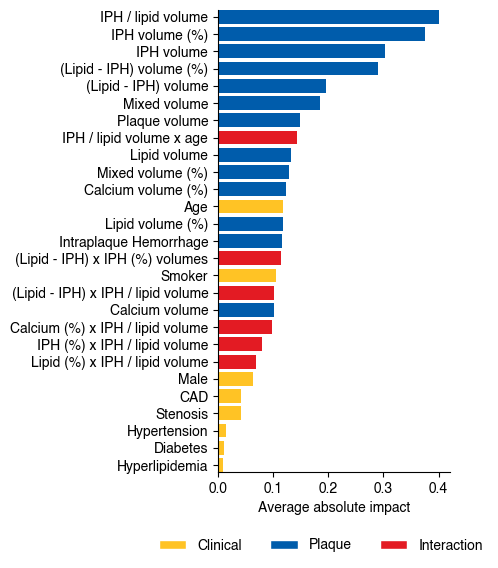

In [93]:
subsets = [clinical_subset, plaque_subset]
colors = ["#FFC325", "#005CAB"]
legend_labels = ["Clinical", "Plaque"]

f, ax = plt.subplots(figsize=(3, 6))

_ , ax = plot_feature_importance(ebm_all, subsets, colors, columns_map, legend_labels, ax)

plt.savefig("../output/plots/TIFF/importance_all.tiff", format="tiff", dpi=500,
                bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})

plt.show()

## Plaque features only

In [27]:
ebm_plaque = load_obj("../output/fitted_models/ebm_plaque.pkl")

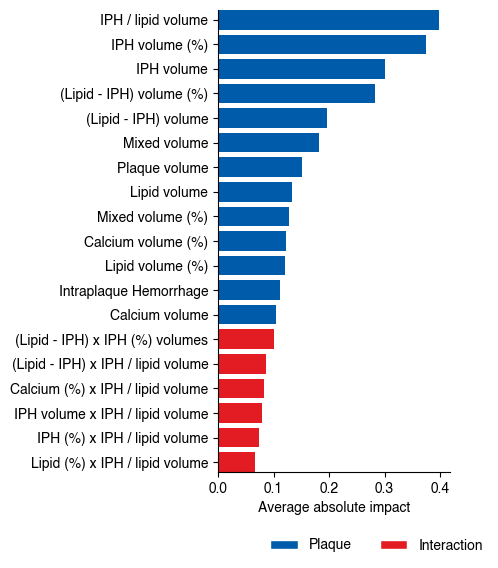

In [94]:
subsets = [plaque_subset]
colors = ["#005CAB"]
legend_labels = ["Plaque"]

f, ax = plt.subplots(figsize=(3, 6))

_ , ax = plot_feature_importance(ebm_plaque, subsets, colors, columns_map, legend_labels, ax)

plt.savefig("../output/plots/TIFF/importance_plaque.tiff", format="tiff", dpi=500,
                bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})

plt.show()

# Local explanation

# Find best threshold
Best classification threshold according to Youden's J index
This threshold maximizes (sensitivity + specificity - 1)

In [34]:
fpr, tpr, thresholds = roc_curve(ground_truths, probas_all)
idx = np.argmax(tpr - fpr)
thresh = thresholds[idx]

In [35]:
thresh

0.23723600934486413

# Plot the feature function of top 6 features

In [67]:
ebm = load_obj("../output/fitted_models/ebm_all.pkl")
ebm_global = ebm.explain_global()
ebm_global.data()["names"]

['plaque_volume',
 'iph_volume',
 'lipid_minus_iph',
 'lipid_volume',
 'mixed_volume',
 'calcium_volume',
 'perc_lipid',
 'perc_mixed',
 'perc_calcium',
 'perc_iph',
 'perc_lipid_minus_iph',
 'iph_total_lipid_ratio',
 'hypertension',
 'CAD',
 'smoker',
 'age',
 'gender',
 'diabetes',
 'lipids',
 'stenosis',
 'iph',
 'lipid_minus_iph x perc_iph',
 'lipid_minus_iph x iph_total_lipid_ratio',
 'perc_lipid x iph_total_lipid_ratio',
 'perc_calcium x iph_total_lipid_ratio',
 'perc_iph x iph_total_lipid_ratio',
 'iph_total_lipid_ratio x age']

In [1078]:
ids = [11, 9, 1, 10, 2, 7]
for i in ids:
    df = pd.DataFrame(columns=["volumes", "logits"])
    df["volumes"] = ebm_global.data(key=i)["names"][:-1]
    df["logits"] = ebm_global.data(key=i)["scores"]
    filename = ebm_global.data()["names"][i]
    print(filename)
    df.to_csv(f"../input/{filename}.csv", index=False)

iph_total_lipid_ratio
perc_iph
iph_volume
perc_lipid_minus_iph
lipid_minus_iph
perc_mixed


(-0.4, 1.1)

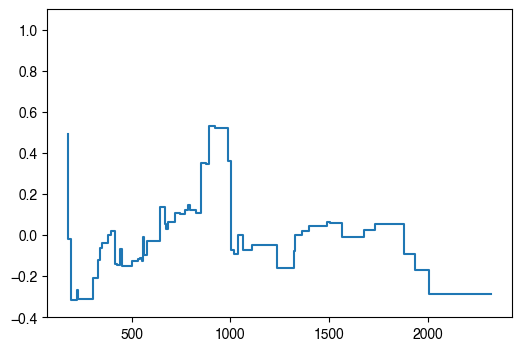

In [1064]:
f, ax3 = plt.subplots(figsize=(6, 4))
ax3.step(ebm_global.data(key=0)["names"][:-1], ebm_global.data(key=0)["scores"])
ax3.set_ylim([-0.4, 1.1])

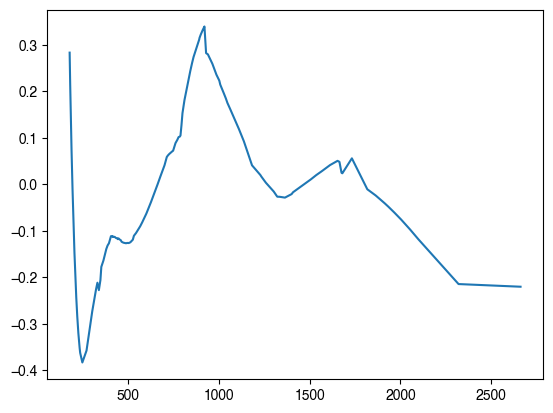

In [1061]:
from loess.loess_1d import loess_1d

f, ax3 = plt.subplots()

xout, yout, wout = loess_1d(np.array(ebm_global.data(key=0)["names"][:-1]), 
                            np.array(ebm_global.data(key=0)["scores"]), 
                            xnew=None, degree=4, frac=0.5,
                            npoints=None, rotate=False, sigy=None)
ax3.plot(xout, yout)
#ax3.set_xticklabels(np.arange(, 694, 10))

plt.show()

In [918]:
wout

array([0.        , 0.46021208, 0.82816454, 0.94521605, 0.84865651,
       0.79979772, 0.68124297, 0.95879691, 0.98305213, 0.91318688,
       0.83613616, 0.74047477, 0.70255403, 0.98774637, 0.98173739,
       0.9739623 , 0.97466467, 0.97275097, 0.96471444, 0.94521605,
       0.98349458, 0.99374122, 0.99804918, 0.98507157, 0.77115473,
       0.75134357, 0.9827896 , 0.1395615 , 0.01792082, 0.98085178,
       0.96240656, 0.97716812, 0.98182647, 0.99831099, 0.99134829,
       0.95393458, 0.93101032, 0.95247258, 0.95940676, 0.97152201,
       0.73907762, 0.70765416, 0.91025249, 0.65326667, 0.59048843,
       0.9606575 , 0.97036642, 0.99689978, 0.99987649, 0.97597481,
       0.99885556, 0.99247643, 0.98887087, 0.97548659, 0.98110016,
       0.97166014, 0.99065949, 0.99421544, 0.96328236, 0.92479577,
       0.94521605, 0.99167212])

# Show 2 case examples

In [36]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, np.where(y_pred_proba >= thresh, 1, 0)).ravel()

In [37]:
for i, (gt, pred) in enumerate(zip(y_test, np.where(y_pred_proba >= thresh, 1, 0))):
    print(f"{i+1} - True: {gt} | predicted: {pred}")


1 - True: 0 | predicted: 0
2 - True: 0 | predicted: 0
3 - True: 0 | predicted: 0
4 - True: 0 | predicted: 0
5 - True: 0 | predicted: 0
6 - True: 0 | predicted: 0
7 - True: 0 | predicted: 0
8 - True: 1 | predicted: 1
9 - True: 0 | predicted: 0
10 - True: 0 | predicted: 0
11 - True: 1 | predicted: 1
12 - True: 1 | predicted: 1
13 - True: 0 | predicted: 0
14 - True: 1 | predicted: 1
15 - True: 0 | predicted: 0
16 - True: 1 | predicted: 0
17 - True: 0 | predicted: 0
18 - True: 1 | predicted: 0
19 - True: 0 | predicted: 0
20 - True: 1 | predicted: 1
21 - True: 1 | predicted: 1
22 - True: 0 | predicted: 0
23 - True: 1 | predicted: 1
24 - True: 0 | predicted: 0
25 - True: 1 | predicted: 1
26 - True: 0 | predicted: 0
27 - True: 0 | predicted: 0
28 - True: 1 | predicted: 0
29 - True: 0 | predicted: 0
30 - True: 0 | predicted: 0
31 - True: 0 | predicted: 0
32 - True: 0 | predicted: 0
33 - True: 1 | predicted: 1
34 - True: 0 | predicted: 0
35 - True: 0 | predicted: 0
36 - True: 0 | predicted: 0
3

In [38]:
pred_labels = np.where(y_pred_proba >= thresh, 1, 0)

tps = []
tns = []

for i, (ytest, ypred) in enumerate(zip(y_test, pred_labels)):
    if ytest == 1 and ypred == 1:
        tps.append(i+1)
    elif ytest == 0 and ypred == 0:
        tns.append(i+1)

In [39]:
tps

[8,
 11,
 12,
 14,
 20,
 21,
 23,
 25,
 33,
 39,
 40,
 44,
 45,
 47,
 49,
 51,
 55,
 57,
 59,
 60,
 74,
 83,
 84,
 85,
 94]

In [59]:
np.array(tns)

array([  1,   2,   3,   4,   5,   6,   7,   9,  10,  13,  15,  17,  19,
        22,  24,  26,  27,  29,  30,  31,  32,  34,  35,  36,  37,  38,
        41,  42,  43,  46,  48,  52,  53,  54,  56,  58,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  75,  76,  78,
        79,  86,  87,  88,  89,  90,  91,  92,  93,  95,  96,  97,  98,
       100, 101, 102, 103, 104, 105, 106])

In [63]:
index = 99
ebm_all.explain_local(X_test_noscale[index:index+1], y_test[index:index+1]).data(key=0)

{'type': 'univariate',
 'names': ['plaque_volume',
  'iph_volume',
  'lipid_minus_iph',
  'lipid_volume',
  'mixed_volume',
  'calcium_volume',
  'perc_lipid',
  'perc_mixed',
  'perc_calcium',
  'perc_iph',
  'perc_lipid_minus_iph',
  'iph_total_lipid_ratio',
  'hypertension',
  'CAD',
  'smoker',
  'age',
  'gender',
  'diabetes',
  'lipids',
  'stenosis',
  'iph',
  'lipid_minus_iph x perc_iph',
  'lipid_minus_iph x iph_total_lipid_ratio',
  'perc_lipid x iph_total_lipid_ratio',
  'perc_calcium x iph_total_lipid_ratio',
  'perc_iph x iph_total_lipid_ratio',
  'iph_total_lipid_ratio x age'],
 'scores': [-0.029736592839625237,
  -0.32632113237813754,
  -0.17305974680352854,
  0.10698674121967765,
  -0.1042786848694303,
  0.03113195579197677,
  0.16407631105100967,
  -0.17857953026417112,
  -0.23698042506439243,
  -0.41147976241773937,
  -0.43927199019182406,
  -0.4025482892033181,
  0.009691010940579056,
  -0.039404584796901364,
  -0.07665232630068347,
  -0.17501751455161618,
  0.0425

In [78]:
def plot_local_importances(X, y, index, colors, columns_map, legend_labels, cat_variables, thresh, ax):   
    if not ax:
        f, ax = plt.subplots(figsize=(5, 6))
    
    local_exp = ebm_all.explain_local(X[index:index+1], y[index:index+1]).data(key=0)
    local_exp_imps = list(zip(local_exp["names"], local_exp["scores"], local_exp["values"]))
    local_exp_imps.sort(key=lambda x:abs(x[1]), reverse=True)
    #local_exp_imps.insert(0, ("Intercept", local_exp["extra"]['scores'][0], ""))

    bar_colors = []
    for (feat_name, score, cov_value) in local_exp_imps:
        if feat_name == "Intercept":
            #bar_colors.append("gray")
            pass
        elif score > 0:
            bar_colors.append(colors[0])
        else:
            bar_colors.append(colors[1])
                
    
    feat_imp = ax.barh(range(len(local_exp_imps)), [i[1] for i in local_exp_imps], color=bar_colors)
    ax.invert_yaxis()
    
    labels = []
    for (feat_name, _, cov_value) in local_exp_imps:
        curr_label = columns_map.get(feat_name, "Intercept")
        curr_label += f" - ({cov_value:.2f})" if isinstance(cov_value, (float)) else f" - ({bool(cov_value)})" if feat_name in cat_variables else cov_value
        labels.append(curr_label)
        
    #columns_map.get(i[0], "Intercept") + f" ({i[2]:.2f})" for i in local_exp_imps
    
    ax.set_yticks(range(len(local_exp_imps)), 
                  #labels=[columns_map.get(i[0], "Intercept") + f" ({i[2]:.2f})" for i in local_exp_imps]
                  labels = labels
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)

    
    #ax.get_xaxis().set_ticks([])
    ax.set_xlabel("Average absolute impact")

    
    legend_handles = []
    for subset_name, subset_color in zip(legend_labels, colors):
        legend_handles.append(Patch(facecolor=subset_color, 
                                    edgecolor="white",
                                    label=subset_name))
    
    ax.get_figure().legend(handles=legend_handles, frameon=False, bbox_to_anchor=(0.88, 0.02), ncol=3)

    #plt.margins(y=0)
    ax.margins(y=0)
    
    new_xticks = np.around(np.arange(-1.7, 0.82, 0.5), 2)
    ax.set_xticks(new_xticks, new_xticks)
    
    
    actual_score = local_exp["perf"]["actual"]
    if actual_score == 1:
        actual = f"Actual score: 1 (symptomatic)"
        pred_score = local_exp["perf"]["predicted_score"]
        predicted = f"Symptomatic score: {pred_score:.2f}"
    else:
        actual = f"Actual score: 0 (asymptomatic)"
        pred_score = 1 - local_exp["perf"]["predicted_score"]
        predicted = f"Symptomatic score: {pred_score:.2f}"

    ax.text(0.03, 0.03, actual, transform=ax.transAxes, size=12)
    ax.text(0.03, 0.08, predicted, transform=ax.transAxes, size=12)
    
    ax.axvline(x = thresh, ymax = 1, 
               linestyle="--",
               color = "gray")
    
    return ax.get_figure(), ax

## True positive (stroke)

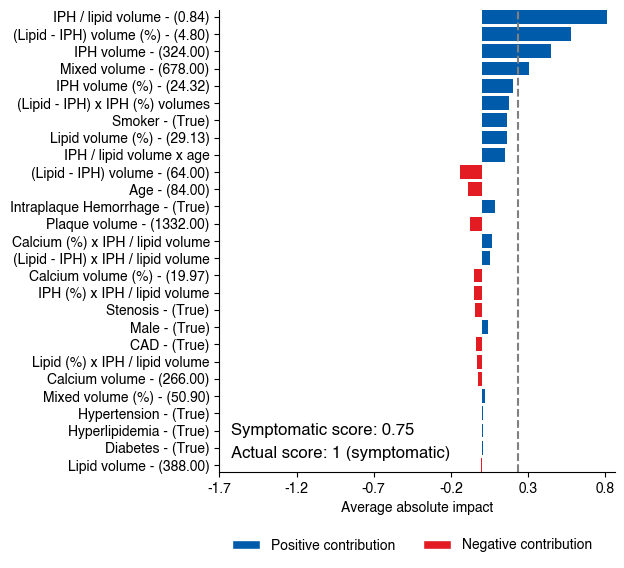

In [80]:
f, ax = plt.subplots(figsize=(5.1, 6))

colors = ["#005CAB", "#E31B23"] # blue, red
legend_labels = ["Positive contribution", "Negative contribution"]
cat_variables = ["hypertension", "CAD", "smoker", "gender", "diabetes", 
                 "lipids", "stenosis", "iph"]

f, ax = plot_local_importances(X_test_noscale, y_test, 
                       index=54, colors=colors, 
                       columns_map = columns_map, 
                       legend_labels = legend_labels, 
                       cat_variables = cat_variables,
                       thresh = thresh,
                       ax = ax)

plt.savefig("../output/plots/TIFF/local_tp.tiff", format="tiff", dpi=500,
                bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})

## True negative (no stroke)

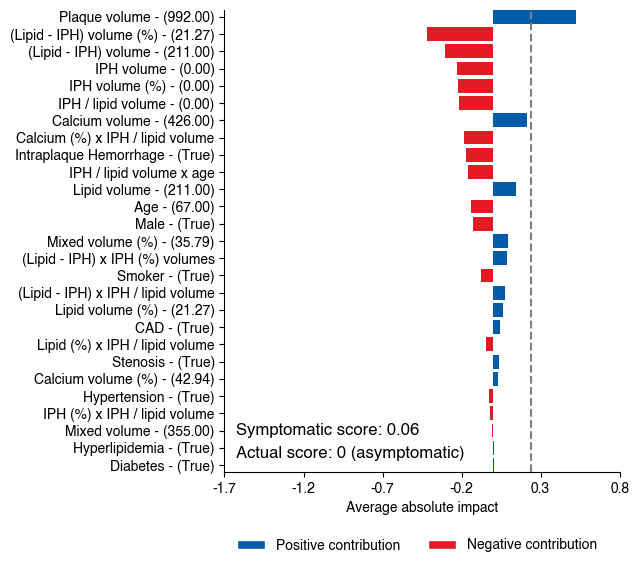

In [82]:
f, ax = plt.subplots(figsize=(5.1, 6))

colors = ["#005CAB", "#E31B23"] # blue, red
legend_labels = ["Positive contribution", "Negative contribution"]

f, ax = plot_local_importances(X_test_noscale, y_test, 
                       index=90, colors=colors, 
                       columns_map = columns_map, 
                       legend_labels = legend_labels, 
                       cat_variables = cat_variables,
                       thresh = thresh,
                       ax = ax)

plt.savefig("../output/plots/TIFF/local_tn.tiff", format="tiff", dpi=500,
                bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})

# Brier score on 10-fold CV

In [111]:
from sklearn.metrics import brier_score_loss

briers = []
algo_name = "ML all"
for gts, probas in zip(cv_preds[algo_name]["gt"], cv_preds[algo_name]["probas"]):
    brier = brier_score_loss(gts, probas[:, 1])
    briers.append(brier)
    
brier_low, brier_med, brier_up = np.percentile(briers, [2.5, 50, 97.5])
print(f"{brier_med:.3f} - [{brier_low:.3f} - {brier_up:.3f}]")

0.112 - [0.050 - 0.239]


# Sensitivity and specificity barplot on 10-fold CV

In [87]:
cv_preds = probas.copy()
cv_preds = {k: v["EBM"] for k,v in cv_preds.items()}

In [88]:
MODELS_LABELS = {
    "ML all": "ML-All",
    "ML plaque": "ML-Plaque",
    "ML ratio": "ML-Ratio",
    "ML clinical": "ML-Clinical"
}

In [89]:
def prep_sens_spec(cv_preds, model_names_labels, 
                   custom_labels_extraction = None,
                   pos_class_idx = 1):
    """
    This function prepares the data necessary to plot sensitivity
    and specificity bars along with comparisons according to
    the McNemar test.
    
    Parameters:
    -----------
    cv_preds:
    
    Returns:
    --------
    sens_spec: Dict
    labels_symptomatic: Dict
    
    """
    labels_pos_class = dict()
    sens_spec = dict()
    
    for algo_name in model_names_labels.keys():
        if algo_name not in sens_spec:
            sens_spec[algo_name] = {"sensitivities": [], "specificities": []}
        if algo_name not in labels_pos_class:
            labels_pos_class[algo_name] = []
        
        for gts, probas in zip(cv_preds[algo_name]["gt"], cv_preds[algo_name]["probas"]):
            
            #labels = np.where(probas_ebm[:, 1] > 0.5, 1, 0)
            #labels_symptomatic[algo_name].append(labels)
            #probas_ebm_reshaped = probas_ebm.reshape(-1, 3)
            #labels = np.argmax(probas_ebm_reshaped, axis=1)
            if custom_labels_extraction:
                labels = custom_labels_extraction(probas)
            else:
                pos_class_probas = probas[:, pos_class_idx]
                
                # compute Youden's J
                fpr, tpr, thresholds = roc_curve(gts, pos_class_probas)
                idx = np.argmax(tpr - fpr)
                thresh = thresholds[idx]
                
                # take labels using Youden's J for thresholding
                # predicted probabilities of the positive class
                labels = np.where(pos_class_probas >= thresh, 1, 0)
                labels_pos_class[algo_name].append(labels)

            tn, fp, fn, tp = confusion_matrix(gts, labels).ravel()

            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)

            sens_spec[algo_name]["sensitivities"].append(sensitivity)
            sens_spec[algo_name]["specificities"].append(specificity)    
    
    for algo_name in model_names_labels.keys():
        mean_sens = np.mean(sens_spec[algo_name]["sensitivities"])
        sens_low, sens_up = np.percentile(sens_spec[algo_name]["sensitivities"], [2.75, 97.5])
        sens_spec[algo_name] = dict(sens_spec[algo_name], **{"mean_sens": mean_sens,
                                                            "sens_low": sens_low,
                                                            "sens_up": sens_up})
        mean_spec = np.mean(sens_spec[algo_name]["specificities"])
        spec_low, spec_up = np.percentile(sens_spec[algo_name]["specificities"], [2.75, 97.5])
        sens_spec[algo_name] = dict(sens_spec[algo_name], **{"mean_spec": mean_spec,
                                                            "spec_low": spec_low,
                                                            "spec_up": spec_up})   
    
    return sens_spec, labels_pos_class

In [90]:
def mcnemar_comparisons(pred_labels_pos_class, target_model, model_names):
    #sens_comparisons = dict()
    sens_comparisons = []

    for algo_name in model_names:
        if algo_name != target_model:
            tb = mcnemar_table(y_target=ground_truths, 
                               y_model1=np.concatenate(pred_labels_pos_class["ML all"]), 
                               y_model2=np.concatenate(pred_labels_pos_class[algo_name]))

            chi2, p = mcnemar(ary=tb, corrected=True)

            #sens_comparisons[algo_name] = p
            sens_comparisons.append((target_model, algo_name, p))
    
    return sens_comparisons

In [91]:
sens_spec, labels_pos_class = prep_sens_spec(cv_preds=cv_preds, 
                                             model_names_labels = MODELS_LABELS, 
                                             custom_labels_extraction = None,
                                             pos_class_idx = 1)

In [116]:
mcnemar_pvalues = mcnemar_comparisons(labels_pos_class, "ML all", model_names = MODELS_LABELS.keys())

In [96]:
from typing import List

def plot_sens_spec_ax(sens_spec, mcnemar_pvalues, 
                      model_names_labels, 
                      target_model,
                      colors,
                      ax=None):
    if not ax:
        f, ax = plt.subplots(figsize=(10, 5))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)

    ax.get_xaxis().set_ticks([])

    w = 0.4

    # Sensitivity
    model_names = [k for k in sens_spec.keys()]
    model_sens = [v["mean_sens"] for _, v in sens_spec.items()]
    model_sens_low = np.array([v["mean_sens"] - v["sens_low"] for _, v in sens_spec.items()])
    model_sens_up = np.array([v["sens_up"] - v["mean_sens"] for _, v in sens_spec.items()])
    
    all_data_sens = list(zip(model_names, 
                            model_sens, 
                            model_sens_low, 
                            model_sens_up))
    all_data_sens.sort(key=lambda x: x[1])

    model_names = [t[0] for t in all_data_sens]
    model_sens = [t[1] for t in all_data_sens]
    model_sens_low = [t[2] for t in all_data_sens]
    model_sens_up = [t[3] for t in all_data_sens]

    bars_sens = ax.bar(np.arange(len(sens_spec.keys()))+w/2+0.03, model_sens, 
                         yerr=[model_sens_low, model_sens_up], 
                         align="center",
                         color=colors["sensitivity"],
                         capsize=3,
                         error_kw=dict(linewidth=1),
                         label="Sensitivity",
                         width=w
                        )

    # Specificity
    model_spec = []
    model_spec_low = []
    model_spec_up = []

    # models are sorted by sensitivity. Follow the same order for
    # specificity
    for model_name in model_names:
        mean_spec = sens_spec[model_name]["mean_spec"]
        model_spec.append(mean_spec)
        model_spec_low.append(mean_spec - sens_spec[model_name]["spec_low"])
        model_spec_up.append(sens_spec[model_name]["spec_up"] - mean_spec)


    bars_spec = ax.bar(np.arange(len(sens_spec.keys()))-w/2-0.03, model_spec, 
                         yerr=[model_spec_low, model_spec_up], 
                         align="center",
                         color=colors["specificity"],
                         capsize=3,
                         error_kw=dict(linewidth=1),
                         label="Specificity",
                         width=w
                        )

    # Annotate sensitivity
    for i, (name, sens, bar, up) in enumerate(zip(model_names, 
                                                 model_sens, 
                                                 ax.patches, 
                                                 model_sens_up)):
        sens = (sens*100)
        ax.annotate(f"{sens:.1f}",
                         (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                         ha='left', va='center',
                         size=16, xytext=(i+w/2+0.17, 0.03),
                         color="white", weight="bold", fontname="Helvetica",
                         textcoords='data') 


    # Annotate specificity
    for i, (name, spec, bar, up) in enumerate(zip(model_names, 
                                                 model_spec, 
                                                 ax.patches, 
                                                 model_sens_up)):
        spec = (spec*100)
        ax.annotate(f"{spec:.1f}",
                         (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                         ha='left', va='center',
                         size=16, xytext=(i-w/2+0.12, 0.03),
                         color="black", weight="bold", fontname="Helvetica",
                         textcoords='data')
    
    ax.invert_xaxis()
    ax.set_xticks(np.arange(len(sens_spec.keys())), labels=model_names, fontsize=13)
    ax.set_ylabel("(%)", fontsize=14)
    ax.set_ylim([0, 1])

    ax.text(3.7, -0.2, "*P < .001", clip_on=False, fontsize=14)

    f.legend(frameon=False, ncol=2, bbox_to_anchor=(0.70, 0.02), fontsize=14)
    
    return f, ax, {"bars_sens": bars_sens, "bars_spec": bars_spec}

#plt.savefig("../Figures/sens_spec.tiff", format="tiff", dpi=1200,
#                bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})

In [97]:
def annot_stat_vertical(star, x1, x2, y, h, col='k', ax=None):
    ax = plt.gca() if ax is None else ax
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col, clip_on=False)
    ax.text((x1+x2)/2, y+h, star, ha='center', va='bottom', color=col, 
            fontsize=14, family="Helvetica")

In [100]:
from typing import Tuple

def add_annotations(comparisons: List[Tuple[str, str, float]], 
                    alpha: float, 
                    bars: matplotlib.container.BarContainer,
                    ax: plt.Axes):
    if not ax:
        raise ValueError("I need a Axes to draw comparisons on.")
    
    width = bars[0].get_width()
    entity_labels = ax.get_xticklabels()
    entity_idx = {label.get_text(): (i + 0.03) for i, label in enumerate(entity_labels)}
    
    y_lim_upper = ax.get_ylim()[1] + 0.05
    v_offset = 0.07
    
    for i, (fst_model, snd_model, P) in enumerate(comparisons):
        P_str = "*" if P <= alpha else f"{P:.3f}"
        annot_stat_vertical(P_str, 
                            entity_idx[fst_model] + w/2, 
                            entity_idx[snd_model] + w/2, 
                            y_lim_upper + (i * v_offset), 0.02,
                            col="black", ax=ax)
    
    return ax

In [115]:
sens_spec["ML plaque"]

{'sensitivities': [1.0,
  1.0,
  0.8571428571428571,
  1.0,
  1.0,
  1.0,
  0.8571428571428571,
  1.0,
  1.0,
  0.7142857142857143,
  0.6666666666666666,
  0.8571428571428571,
  1.0,
  0.8571428571428571,
  1.0,
  1.0,
  1.0,
  0.8571428571428571,
  0.8571428571428571,
  0.7142857142857143,
  0.8333333333333334,
  1.0,
  1.0,
  0.8571428571428571,
  0.5714285714285714,
  0.7142857142857143,
  0.8571428571428571,
  1.0,
  1.0,
  0.8571428571428571,
  1.0,
  1.0,
  1.0,
  0.7142857142857143,
  0.8571428571428571,
  1.0,
  0.7142857142857143,
  0.8571428571428571,
  0.8571428571428571,
  0.8571428571428571,
  1.0,
  0.8571428571428571,
  1.0,
  1.0,
  0.8571428571428571,
  0.8571428571428571,
  1.0,
  0.5714285714285714,
  1.0,
  0.8571428571428571,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8571428571428571,
  0.8571428571428571,
  0.8571428571428571,
  0.7142857142857143,
  1.0,
  0.7142857142857143,
  1.0,
  0.8571428571428571,
  1.0,
  0.8571428571428571,
  0.42857142857142855,
  1.0,
  0.857142

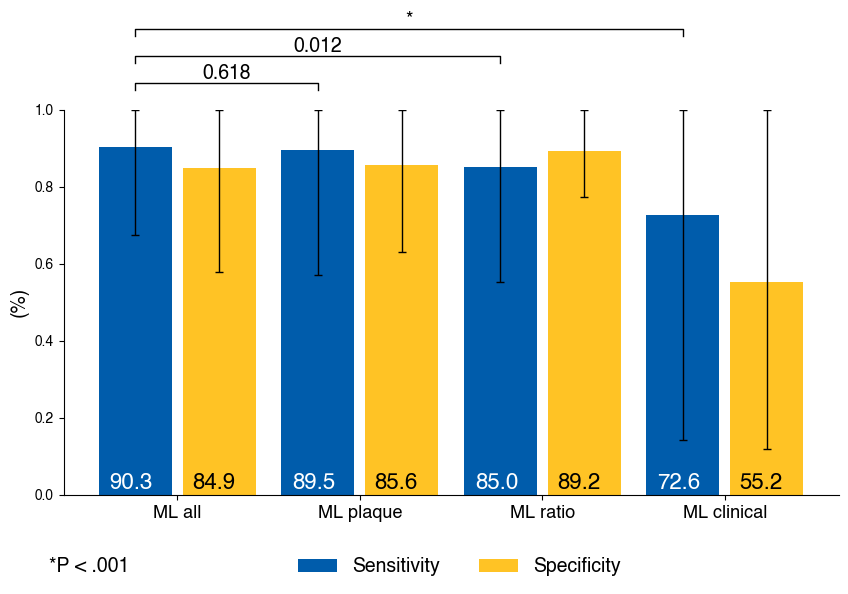

In [508]:
from typing import List, Tuple

f, ax, bars = plot_sens_spec_ax(sens_spec, mcnemar_pvalues, MODELS_LABELS,
                          target_model="ML all", 
                          colors = {"sensitivity": "#005CAB", "specificity": "#FFC325"},
                          ax=None)

ax = add_annotations(mcnemar_pvalues, alpha = 0.001, bars=bars["bars_sens"], ax=ax)

plt.savefig("../output/plots/TIFF/sens_spec.tiff", format="tiff", dpi=500,
                bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})

# Sensitivity and specificity on external validation set

In [526]:
from scipy.stats import binomtest

# Compute sensitivity and specificity 
def get_sens_spec_youden(cv_preds, y_test, y_pred_proba_test, model_name, ret_cis=False):
    fpr, tpr, thresholds = roc_curve(cv_preds[model_name]["gt_conc"], cv_preds[model_name]["probas_conc"][:, 1])
    idx = np.argmax(tpr - fpr)
    thresh = thresholds[idx]
    
    labels = np.where(y_pred_proba_test >= thresh, 1, 0)        

    tn, fp, fn, tp = confusion_matrix(y_test, labels).ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    sens_test = binomtest(k=tp, n=(tp+fn), p=0.5)
    sens_low, sens_up = sens_test.proportion_ci(method="wilsoncc")


    spec_test = binomtest(k=tn, n=(tn+fp), p=0.5)  
    spec_low, spec_up = spec_test.proportion_ci(method="wilsoncc")    
    
    to_return = (thresh, sensitivity, specificity)
    
    if ret_cis:
        to_return += (sens_low, sens_up, spec_low, spec_up)
        
    return to_return

In [527]:
get_sens_spec_youden(cv_preds, y_test, y_pred_proba, "ML all", ret_cis=True)

(0.23723600934486413,
 0.8064516129032258,
 0.96,
 0.6194052584925055,
 0.9187558834426435,
 0.8797131079240075,
 0.9896125436509398)